# Thermal evolution of exoplanetary cores

This code solves for the thermal evolution of the cores of planets having different mass and iron content. The structural profiles (density, temperature, etc.), initial inner core sizes (if any) of these bodies, along with the CMB heat flux evolution, are obtained from a model developed by Lena Noack. For now, the code solves the energy balance equation as in Labrosse (2015).

Todo: Entropy balance, dynamo evolution,...

## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf
import scipy.integrate as integrate
import yaml
import pandas as pd
import sys
from scipy.optimize import minimize_scalar

## Constants

In [2]:
year = 365.25*3600*24 # 1 year (s)
GC = 6.67e-11         # Gravitational constant (m3 kg-1 s-2)
Ak = 2.39             # Radial dependence of conductivity
beta = 0.2            # Saturation constant for fast rotating polar dynamos
mu_0 = 4*np.pi*1e-7   # Magnetic permeability (Hm-1)
M_Earth = 5.972e24    # Mass of the Earth (kg)

#g_c = 5 # Core gravity (estimated)
k_c = 150 # Core thermal conductivity
magn_moment_Earth = 7.8e22 # Magnetic moment Earth (Am2)

## Rocky planet class 

Defines physical parameters of a given planet. Parameters are read from yaml files.

In [3]:
class Rocky_Planet():

    def __init__(self):
        self.parameters()

    def parameters(self):
        pass 

    def read_parameters(self, file): 
        """Read parameters from yaml file"""
        with open(file, 'r') as stream:
            try:
                dict_param = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print(exc)
        for k, v in dict_param.items():
            setattr(self, k, float(v))

## Evolution class

Calculates the thermal evolution of a given planet.

In [4]:
class Evolution():

    def __init__(self, planet):
        self.planet = planet
        
        '''Initialize matrices'''
        self.r_IC = np.zeros_like(self.planet.time_vector)
        self.drIC_dt = np.zeros_like(self.planet.time_vector)
        self.T = np.zeros_like(self.planet.time_vector)
        self.dT_dt = np.zeros_like(self.planet.time_vector)
        self.PC = np.zeros_like(self.planet.time_vector)
        self.PL = np.zeros_like(self.planet.time_vector)
        self.PX = np.zeros_like(self.planet.time_vector)
        self.QC = np.zeros_like(self.planet.time_vector)
        self.QL = np.zeros_like(self.planet.time_vector)
        self.QX = np.zeros_like(self.planet.time_vector)
        self.Q_CMB = np.zeros_like(self.planet.time_vector)
        self.T_CMB = np.zeros_like(self.planet.time_vector)
        self.SC = np.zeros_like(self.planet.time_vector)
        self.TC = np.zeros_like(self.planet.time_vector)
        self.SR = np.zeros_like(self.planet.time_vector)
        self.TR = np.zeros_like(self.planet.time_vector)
        self.Sk = np.zeros_like(self.planet.time_vector)
        self.Tphi = np.zeros_like(self.planet.time_vector)
        self.phi = np.zeros_like(self.planet.time_vector)
        self.qc_ad = np.zeros_like(self.planet.time_vector)
        self.F_th = np.zeros_like(self.planet.time_vector) 
        self.F_X = np.zeros_like(self.planet.time_vector)
        self.Bc = np.zeros_like(self.planet.time_vector)
        self.Bs = np.zeros_like(self.planet.time_vector)
        self.M = np.zeros_like(self.planet.time_vector)
        self.g_c = np.zeros_like(self.planet.time_vector)
        self.M_ratio = np.zeros_like(self.planet.time_vector)
        self.Delta_time = self.planet.time_vector.diff()*year 
                
        '''Initial temperature at the center T0'''
        '''If no initial inner core, T0 same as in yaml parameter file'''
        '''If initial inner core, define T0 by using the melting temperature'''
        if self.planet.r_IC_0 == 0.0:
            self.T[0] = self.planet.T0                        
        else:    
            self.T[0] = self.T_melt(self.planet.r_IC_0) 
            
        '''Initial inner core radius, powers, CMB heat flux (set to 0 for now), CMB temperature'''
        self.r_IC[0] = self.planet.r_IC_0
        #self.PC[0] = self._PC(self.r_IC[0])
        #self.PL[0] = self._PL(self.r_IC[0])
        #self.PX[0] = self._PX(self.r_IC[0])
        self.Q_CMB[0] = 0.
        self.T_CMB[0] = self.T_adiabat(self.planet.r_OC,self.T[0])
                          
    '''Run evolution model'''         
    def run(self):
        
        for i,time in enumerate(self.planet.time_vector[1:]):
            
            '''No initial inner core --> update_noic routine'''
            if self.r_IC[i] == 0.0 and self.T[i] > self.planet.TL0:
                              
                T, dT_dt,r_IC, drIC_dt, PC, PL, PX, Q_CMB, T_CMB, QC, QL, QX, SC, TC, SR, TR, Sk,Tphi, phi,qc_ad, F_th, F_X, Bc, Bs, M,M_ratio =  self.update_noic(self.T[i],self.Delta_time[i+1],self.planet.qcmb[i])
                '''Shift updated value to the next time step'''
                self.T[i+1] = T 
                self.dT_dt[i+1] = dT_dt
                self.r_IC[i+1] = r_IC
                self.drIC_dt[i+1] = drIC_dt
                self.PC[i+1] = PC
                self.PL[i+1] = PL
                self.PX[i+1] = PX
                self.Q_CMB[i+1] = Q_CMB
                self.T_CMB[i+1] = T_CMB
                self.QC[i+1] = QC
                self.QL[i+1] = QL
                self.QX[i+1] = QX
                self.SC[i+1] = SC
                self.TC[i+1] = TC
                self.SR[i+1] = SR
                self.TR[i+1] = TR
                self.Sk[i+1] = Sk
                self.Tphi[i+1] = Tphi
                self.phi[i+1] = phi
                self.qc_ad[i+1] = qc_ad
                self.F_th[i+1] = F_th
                self.F_X[i+1] = F_X
                self.Bc[i+1] = Bc
                self.Bs[i+1] = Bs
                self.M[i+1] = M
                self.M_ratio[i+1] = M_ratio
                 
                '''For the first step at which an inner core starts forming, look for the inner core radius'''
                if self.T[i+1] < self.planet.TL0:
                    self.r_IC[i+1] = self.find_r_IC(T)     
            else:                 
               
                '''Initial inner core --> update_ic routine'''  
                T, r_IC, drIC_dt, PC, PL, PX, Q_CMB, T_CMB, QC, QL, QX, SC, Sk, Tphi, phi,qc_ad, F_th, F_X, Bc, Bs, M,M_ratio =  self.update_ic(self.r_IC[i], self.Delta_time[i+1],self.planet.qcmb[i])
                self.T[i+1] = T
                self.r_IC[i+1] = r_IC
                self.drIC_dt[i+1] = drIC_dt
                self.PC[i+1] = PC
                self.PL[i+1] = PL
                self.PX[i+1] = PX
                self.Q_CMB[i+1] = Q_CMB
                self.T_CMB[i+1] = T_CMB   
                self.QC[i+1] = QC
                self.QL[i+1] = QL
                self.QX[i+1] = QX
                self.SC[i+1] = SC
                self.Sk[i+1] = Sk
                self.Tphi[i+1] = Tphi
                self.phi[i+1] = phi
                self.qc_ad[i+1] = qc_ad
                self.F_th[i+1] = F_th
                self.F_X[i+1] = F_X
                self.Bc[i+1] = Bc
                self.Bs[i+1] = Bs
                self.M[i+1] = M
                self.M_ratio[i+1] = M_ratio
        
        for i in range(1,len(self.planet.time_vector)-1):
            if self.M[i-1]==0 and self.M[i]!=0:
                t_start = self.planet.time_vector[i]
            if self.M[i+1]==0 and self.M[i]!=0 and self.M[i-1]!=0:
                t_end = self.planet.time_vector[i]
                t_mf = t_end - t_start
             
        print ("The magnetic field lifetime is %.1f billion years."%(t_mf*1e-9))       
        
        '''Figures'''
        plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
        plt.subplot(1, 2, 1) 
        plt.plot(self.planet.time_vector,self.T,'+')
        plt.xlabel('Time (years)')
        plt.ylabel('Temperature at the center/ICB (K)')
        plt.gca().set_xlim(left=0) 
        plt.subplot(1, 2, 2)
        plt.plot(self.planet.time_vector,self.r_IC/1e3,'+')
        plt.xlabel('Time (years)')
        plt.ylabel('Inner core radius (km)')
        plt.gca().set_xlim(left=0)
        plt.subplots_adjust(wspace=0.4)
        plt.show()

        plt.plot(self.planet.time_vector,self.QC, label='Secular cooling')
        plt.plot(self.planet.time_vector,self.QL,label='Latent heat')
        plt.plot(self.planet.time_vector,self.QX, label='Gravitational heat')
        plt.plot(self.planet.time_vector,self.QL+self.QC+self.QX, label='Total')
        plt.xlabel('Time (years)')
        plt.ylabel('Contributions to energy balance (W)')
        plt.gca().set_xlim(left=0)
        plt.legend()
        plt.show()
        
        plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
        plt.subplot(1, 2, 1)  
        plt.plot(self.planet.time_vector,self.Q_CMB,'+')
        plt.xlabel('Time (years)')
        plt.ylabel('CMB heat flow (W)')
        plt.gca().set_xlim(left=0)  
        plt.subplot(1, 2, 2)         
        plt.plot(self.planet.time_vector,self.T_CMB,'+')
        plt.xlabel('Time (years)')
        plt.ylabel('CMB temperature (K)')
        plt.gca().set_xlim(left=0) 
        plt.subplots_adjust(wspace=0.4)
        plt.show()
        
        plt.plot(self.planet.time_vector,self.phi,'+')
        plt.xlabel('Time (years)')
        plt.ylabel('Efficiency factor $\Phi$')
        plt.gca().set_xlim(left=0) 
        plt.show()
        
        plt.plot(self.planet.time_vector,self.F_th,'+', label='Thermal')
        plt.plot(self.planet.time_vector,self.F_X,'+', label='Buoyancy')
        plt.xlabel('Time (years)')
        plt.ylabel('Buoyancy fluxes ($m^{2}s^{-3}$)')
        plt.gca().set_xlim(left=0) 
        plt.legend()
        plt.show()
        
        plt.figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
        plt.subplot(1, 2, 1)  
        plt.plot(self.planet.time_vector,self.Bc * 1e3,'+',label='CMB')
        plt.plot(self.planet.time_vector,self.Bs * 1e3,'+',label='Surface')
        plt.xlabel('Time (years)')
        plt.ylabel('rms dipole field (mT)')
        plt.gca().set_xlim(left=0) 
        plt.legend()
        ax1 = plt.subplot(1, 2, 2) 
        ax1.plot(self.planet.time_vector,self.M,'+')
        ax1.set_ylabel('Magnetic moment ($A m^{2}$)')
        ax2 = ax1.twinx()  
        color = 'tab:blue'               
        ax2.set_ylabel('Magnetic moment Earth ($A m^{2}$)', color=color)  
        ax2.plot(self.planet.time_vector,self.M_ratio,'+')
        ax2.tick_params(axis='y', labelcolor=color)
        plt.xlabel('Time (years)')
        plt.gca().set_xlim(left=0) 
        plt.subplots_adjust(wspace=0.4)
        plt.show()
        
    '''Functions for calculations'''    
    def dTL_dr_IC(self, r):
        ''' Melting temperature jump at ICB (to be modified) '''
        return -self.planet.K_c * 2.*self.planet.dTL_dP * r / self.planet.L_rho**2. \
            + 3. * self.planet.dTL_dchi * self.planet.chi0 * r**2. / (self.planet.L_rho**3. * self.fC(self.planet.r_OC / self.planet.L_rho, 0.))

    def fC(self, r, delta): 
        '''fC (Eq. A1 Labrosse 2015)'''
        return r**3. * (1 - 3. / 5. * (delta + 1) * r**2.- 3. / 14. * (delta + 1) \
            * (2 * self.planet.A_rho - delta) * r**4.)

    def fX(self, r, r_IC):
        '''fX (Eq. A15 Labrosse 2015)'''
        return (r)**3. * (-r_IC**2. / 3. / self.planet.L_rho**2. + 1./5. * (1.+r_IC**2./self.planet.L_rho**2.) \
                *(r)**2.-13./70. * (r)**4.) 

    def rho(self, r):
        ''' Density (Eq. 5 Labrosse 2015)'''
        return self.planet.rho_c * (1. - r**2. / self.planet.L_rho**2. - self.planet.A_rho * r**4. / self.planet.L_rho**4.)

    def T_melt(self, r):
        ''' Melting temperature (Eq. 14 Labrosse 2015)'''
        return self.planet.TL0 - self.planet.K_c * self.planet.dTL_dP * r**2. / self.planet.L_rho**2. + self.planet.dTL_dchi * self.planet.chi0 * r**3. \
                / (self.planet.L_rho**3. * self.fC(self.planet.r_OC / self.planet.L_rho, 0.))
        #return 6500*(p/340)**(0.515) * (1./(1-np.log(XS * 1e-2)))    # XS is the amount of light elements

    def _PL(self, r):
        '''Latent heat power'''
        return 4. * np.pi * r**2. * self.T_melt(r) * self.rho(r) * self.planet.DeltaS


    def _PC(self, r):
        '''Secular cooling power (Eq. A8 Labrosse 2015)'''
        return -4. * np.pi / 3. * self.planet.rho_c * self.planet.CP * self.planet.L_rho**3. *\
                (1 - r**2. / self.planet.L_rho**2 - self.planet.A_rho* r**4. / self.planet.L_rho**4.)**(-self.planet.gamma) \
                * (self.dTL_dr_IC(r) + 2. * self.planet.gamma \
                * self.T_melt(r) * r / self.planet.L_rho**2. *(1 + 2. * self.planet.A_rho * r**2. / self.planet.L_rho**2.) \
                /(1 - r**2. / self.planet.L_rho**2. - self.planet.A_rho * r**4. / self.planet.L_rho**4.)) \
                * (self.fC(self.planet.r_OC / self.planet.L_rho, self.planet.gamma))

    def _PX(self, r):
        ''' Gravitational heat power (Eq. A14 Labrosse 2015)'''
        return 8 * np.pi**2 * self.planet.chi0 * GC * self.planet.rho_c**2 * self.planet.beta * r**2. \
        * self.planet.L_rho**2. / self.fC(self.planet.r_OC / self.planet.L_rho, 0) \
        * (self.fX(self.planet.r_OC / self.planet.L_rho, r) - self.fX(r / self.planet.L_rho, r))

    def pressure_diff(self,r):  
        '''Pressure difference (GPa)'''
        K0 = self.planet.L_rho**2/3.*2.*np.pi*GC*self.planet.rho_c**2 /1e9 #in GPa
        parenthesis = r**2/self.planet.L_rho**2-4./5.*r**4/self.planet.L_rho**4
        return -K0*parenthesis
    
    def T_adiabat(self,r,T):
        '''Adiabatic temperature (from Labrosse, to be modified!)''' 
        return T*(1-r**2/self.planet.L_rho**2-self.planet.A_rho*r**4/self.planet.L_rho**4)**self.planet.gamma
    
    '''Routine for no initial inner core'''
    def update_noic(self,T,Delta_time,qcmb):
        
        fC = self.fC(self.planet.r_OC / self.planet.L_rho, self.planet.gamma)
        
        ''' Secular cooling power '''
        PC = (-4*np.pi/3*self.planet.rho_c*self.planet.CP*self.planet.L_rho**3*fC)
        
        ''' Latent heat power '''
        PL = 0.

        ''' Gravitational heat power '''
        PX = 0.      
        
        '''CMB heat flow'''
        Q_CMB = 4*np.pi*self.planet.r_OC**2*qcmb
        
        '''Temperature increase at center'''
        dT_dt = Q_CMB/PC 
        
        ''' New central temperature '''
        T = T + dT_dt * Delta_time  
        
        ''' Inner core growth '''
        drIC_dt = 0.
        
        ''' Inner core size'''
        r_IC = 0.
        
        '''Temperature at CMB'''
        T_CMB = self.T_adiabat(self.planet.r_OC,T)
        
        '''Secular cooling power'''
        QC = PC * dT_dt
        
        ''' Latent heat power '''
        QL = 0.

        ''' Gravitational heat power '''
        QX = 0. 
        
        '''Entropy contribution of secular cooling'''
        SC = self._SC(r_IC,drIC_dt)
        
        TC = self._TC(r_IC)
        
        '''Entropy contribution of radiocativity (assumed to be 0)'''
        SR = 0.
        
        TR = self._TR(r_IC)
        
        '''Entropy contribution of conduction'''
        Sk = self._Sk(r_IC)
        
        '''Dissipation temperature'''
        Tphi = self._Tphi(T,r_IC)
        
        '''Efficiency factor'''
        phi = self._eff_noic(Tphi,TC,T_CMB,QC,TR,0,Sk)
        
        '''Isentropic heat flux'''
        qc_ad = self._qc_ad(k_c,T_CMB,r_IC)

        '''Gravity at CMB'''
        g_c = self._gravity_CMB(XFe,FeM,Mp)
        
        '''Thermal buoyancy'''
        F_th = self._F_th(g_c,qcmb,qc_ad)
        
        '''Compositional buoyancy'''
        F_X = self._F_X(g_c,r_IC,drIC_dt)
        
        R_planet = self._R_planet(XFe,Mp)
        rho_OC = self._density(self.planet.r_OC)
        
        '''rms dipole field @ CMB'''
        Bc = self._Bc(rho_OC,F_th,F_X,r_IC)
        
        '''rms dipole field @ surface'''
        Bs = self._Bs (Bc,R_planet)
        
        '''Magnetic moment (Am2)'''
        M = self._magn_moment(rho_OC,F_th,F_X,r_IC)
        
        M_ratio = M/magn_moment_Earth
                
        return T, dT_dt,r_IC, drIC_dt, PC, PL, PX, Q_CMB, T_CMB, QC, QL, QX, SC, TC, SR, TR, Sk,Tphi, phi, qc_ad, F_th, F_X, Bc, Bs, M, M_ratio
    
    '''Routine for initial inner core'''    
    def update_ic(self, r_IC, Delta_time,qcmb):
        
        '''Secular cooling power'''
        PC = self._PC(r_IC)
        
        '''Latent heat power'''
        PL = self._PL(r_IC)
        
        '''Gravitational heat power'''
        PX = self._PX(r_IC)
        
        '''CMB heat flow'''
        Q_CMB = 4*np.pi*self.planet.r_OC**2*qcmb
        
        '''Inner core growth rate'''
        drIC_dt = Q_CMB/(PC + PL + PX)
        
        '''Inner core radius'''
        r_IC = r_IC + drIC_dt * Delta_time
        
        '''Temperature at the ICB'''
        T = self.T_melt(r_IC)
        
        '''CMB temperature'''
        T_CMB = self.T_adiabat(self.planet.r_OC,T)
        
        '''Secular cooling power'''
        QC = PC*drIC_dt
        
        '''Latent heat power'''
        QL = PL*drIC_dt
        
        '''Gravitational heat power'''
        QX = PX*drIC_dt
        
        '''Entropy contribution of secular cooling'''
        SC = self._SC(r_IC,drIC_dt)
        
        TC = self._TC(r_IC)
        
        '''Entropy contribution of radiocativity (assumed to be 0)'''
        SR = 0.
        
        TR = self._TR(r_IC)

        '''Entropy contribution of conduction'''
        Sk = self._Sk(r_IC)
        
        '''Dissipation temperature'''
        Tphi = self._Tphi(T,r_IC)
        
        '''Efficiency factor'''
        phi = self._eff_ic(Tphi,TC,T_CMB,QC,TR,0,Sk,QX,T,QC,QL) 
        
        '''Isentropic heat flux'''
        qc_ad = self._qc_ad(k_c,T_CMB,r_IC)
        
        '''Gravity at CMB'''
        g_c = self._gravity_CMB(XFe,FeM,Mp)
                
        '''Thermal buoyancy'''
        F_th = self._F_th(g_c,qcmb,qc_ad)
        
        '''Compositional buoyancy'''
        F_X = self._F_X(g_c,r_IC,drIC_dt)
        
        R_planet = self._R_planet(XFe,Mp)
        rho_OC = self._density(self.planet.r_OC)
                
        '''rms dipole field @ CMB'''
        Bc = self._Bc(rho_OC,F_th,F_X,r_IC)
        
        '''rms dipole field @ surface'''
        Bs = self._Bs (Bc,R_planet)
                
        '''Magnetic moment (Am2)'''
        M = self._magn_moment(rho_OC,F_th,F_X,r_IC)
        
        M_ratio = M/magn_moment_Earth
                                        
        return T,r_IC, drIC_dt, PC, PL, PX, Q_CMB, T_CMB, QC, QL, QX, SC, Sk, Tphi, phi,qc_ad, F_th, F_X, Bc, Bs, M, M_ratio

    
    '''Find inner core radius when it first starts forming'''
    def find_r_IC(self, T0):       
        def Delta_T(radius):
            #P = self.pressure_diff(radius, rho_0, Lrho, Arho)+P0
            Ta = self.T_adiabat(radius,T0)
            TL = self.T_melt(radius)
            return (Ta - TL)**2
        res = minimize_scalar(Delta_T, bounds=(0., 6e6), method='bounded') #, constraints={'type':'ineq', 'fun': lambda x: x})  #result has to be >0
        r_IC = res.x
        if r_IC < 1: r_IC = np.array(0.)
        return r_IC.tolist()
    
    def _SC(self,r,drIC_dt):
        '''Entropy contribution of secular cooling (Labrosse 2015, Eq. A11)'''
        return (-4 * np.pi * self.planet.rho_c * self.planet.CP * self.planet.L_rho**3)/(3*self.T_melt(r)) * (self.dTL_dr_IC(r) \
                + 2 * self.planet.gamma * self.T_melt(r)*r/self.planet.L_rho**2 *(1 + 2 * self.planet.A_rho * r**2 / self.planet.L_rho**2) \
                /(1 - r**2 / self.planet.L_rho**2 - self.planet.A_rho * r**4 / self.planet.L_rho**4)) * (self.fC(self.planet.r_OC/self.planet.L_rho,0) \
                - self.fC(r/self.planet.L_rho,0)) * drIC_dt
    
    def _TC(self,r):
        '''Temperature at which secular cooling contributes to the entropy balance (Labrosse 2015, Eq. A12)'''
        return self.T_melt(r) * (1 - r**2 / self.planet.L_rho**2 - self.planet.A_rho * r**4 / self.planet.L_rho**4)**(-self.planet.gamma) \
                * (self.fC(self.planet.r_OC/self.planet.L_rho,self.planet.gamma) - self.fC(r/self.planet.L_rho,self.planet.gamma)) \
                / (self.fC(self.planet.r_OC/self.planet.L_rho,0)-self.fC(r/self.planet.L_rho,0))
    
    def _SR(self,h,r):
        '''Entropy contribution from radiogenic heating (Labrosse 2015, Eq. A18)'''
        return 4 * np.pi * self.planet.rho_c * self.planet.L_rho**3 * h / (3 * T_melt(r)) * (1 - r**2/self.planet.L_rho**2 - self.planet.A_rho \
                * r**4/self.planet.L_rho**4)**(-self.planet.gamma) * (fC(self.planet.r_OC/self.planet.L_rho,-self.planet.gamma) - fC(r/self.planet.L_rho,-self.planet.gamma))
    
    def _TR(self,r):
        '''Temperature at which radiogenic dissipation occurs (Labrosse 2015, Eq. A19)'''
        return self.T_melt(r) * (1-r**2/self.planet.L_rho**2 - self.planet.A_rho * r**4 / self.planet.L_rho**4)**(self.planet.gamma) \
                * (self.fC(self.planet.r_OC/self.planet.L_rho,0) - self.fC(r/self.planet.L_rho,0)) \
                / (self.fC(self.planet.r_OC/self.planet.L_rho,-self.planet.gamma) - self.fC(r/self.planet.L_rho,-self.planet.gamma))
        
    def _Sk(self,r):
        '''Contribution of conduction to the entropy balance (Labrosse 2015, Eq. A20)'''
        return 16 * np.pi * self.planet.gamma**2 * self.planet.k_c * self.planet.L_rho * (self.fk(self.planet.r_OC/self.planet.L_rho)-self.fk(r/self.planet.L_rho))
    
    def fk(self,x):
        '''Labrosse 2015, Eq. A23'''
        return x**5 / 5. * (1 + 5./7. * (2 - Ak + 4 * self.planet.A_rho)*x**2 + 5./9. *(3 + 10 * self.planet.A_rho + 4 * self.planet.A_rho**2 \
                - 2 * Ak *(1 + 2 * self.planet.A_rho))* x**4)
    
    def _Tphi(self,T,r):
        '''Effective dissipation temperature (Labrosse 2015, Eq. A24)'''
        '''T is T_melt(r_IC) when there is an inner core, T0 when there is no inner core'''
        return T / ((1 - r**2 / self.planet.L_rho**2 - self.planet.A_rho * r**4/self.planet.L_rho**4)**(self.planet.gamma)) \
                * (self.fC(self.planet.r_OC/self.planet.L_rho,0)-self.fC(r/self.planet.L_rho,0)) \
                / (self.fC(self.planet.r_OC/self.planet.L_rho,-self.planet.gamma)-self.fC(r/self.planet.L_rho,-self.planet.gamma))
    
    def _eff_noic(self,Tphi,TC,T_CMB,QC,TR,QR,Sk):
        '''Efficiency factor before inner core crystallization (Labrosse 2015, Eq. 40)'''
        return Tphi * (TC-T_CMB) / (T_CMB * TC) * QC + Tphi * (TR - T_CMB)/(T_CMB * TR) * QR - Tphi * Sk
    
    def _eff_ic(self,Tphi,TC,T_CMB,QC,TR,QR,Sk, QX,T_ICB,QICB,QL):
        '''Efficiency factor when there is an inner core (Labrosse 2015, Eq. 35)'''
        return Tphi * (TC-T_CMB) / (T_CMB * TC) * QC + Tphi * (TR - T_CMB)/(T_CMB * TR) * QR - Tphi * Sk \
                + Tphi / T_CMB * QX + (Tphi * (T_ICB-T_CMB)/(T_CMB * T_ICB)) * (QICB + QL)
    
    def _Bc(self,rho_OC,F_th,F_X,r_IC):
        '''rms dipole field intensity at the CMB (Olson + Christensen 2006, unit:T)'''
        return beta * np.sqrt(rho_OC * mu_0) * ((F_th+F_X)*self.planet.r_OC)**(1./3.)
    
    def _Bs (self,Bc,r_planet):
        '''rms dipole field intensity at the planetary surface, unit:T'''
        return Bc * (self.planet.r_OC/r_planet)**3 
    
    #def magn_moment(self,Bc):
        '''Magnetic moment, unit:Am2 (Olson & Christensen 2006)'''
        #return (4 * np.pi * self.planet.r_OC**3 * Bc) / (np.sqrt(2) * mu_0)
    def _magn_moment(self,rho_OC,F_th,F_X,r_IC):
        if (F_th +F_X) < 0:
            return 0
        else:
            return 4 * np.pi * self.planet.r_OC**3 * beta * np.sqrt(rho_OC/mu_0) * ((F_th + F_X)*(self.planet.r_OC-r_IC))**(1/3)
    
    def _buoyancy_flux(self,F_th,F_X):
        '''Buoyancy flux (from Driscoll and Bercovici, eq. 35)'''
        return F_th + F_X
    
    def _F_th(self,g_c,q_cmb,qc_ad):
        '''Thermal buoyancy'''
        return self.planet.alpha_c * g_c / self.planet.rho_c / self.planet.CP * (q_cmb - qc_ad)
    
    def _qc_ad(self,k_c,T_cmb,r_IC):
        '''Isentropic heat flux at the CMB, unit: W m-2'''
        return k_c * T_cmb * self.planet.r_OC / (6340000)**2
    
    def _F_X(self,g_c,r_IC,drIC_dt):
        '''Compositional buoyancy'''
        return g_c * r_IC / self.planet.r_OC * self.planet.Deltarho_ICB /self.planet.rho_c * (r_IC/self.planet.r_OC)**2 * drIC_dt
    
    def _density(self,r):
        '''Planetary density'''
        return self.planet.rho_c * (1-r**2/self.planet.L_rho**2 - self.planet.A_rho * r**4/self.planet.L_rho**4)
    
    def _R_planet(self, XFe,Mp):
        '''Planetary radius (Noack + Lasbleis paper), unit: m'''
        return (7030 - 1840 * XFe*1e-2)*(Mp)**(0.282) * 1000
    
    def _gravity_CMB(self,XFe,FeM,Mp):
        '''Gravity @ CMB (Noack & Lasbleis)'''
        X_CMF = (XFe*1e-2 - FeM*1e-2)/(1-FeM*1e-2)
        return GC*X_CMF*Mp*M_Earth/(self.planet.r_OC)**2

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:493: RuntimeWarning: invalid value encountered in double_scalars


The magnetic field lifetime is 4.1 billion years.


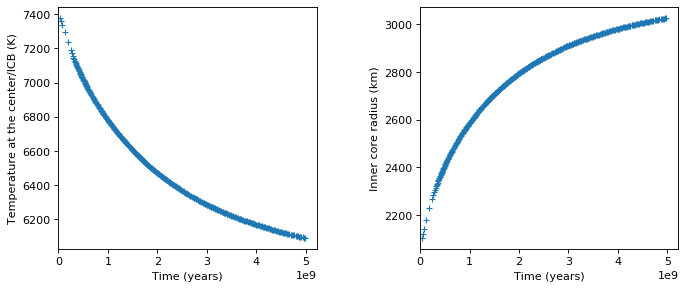

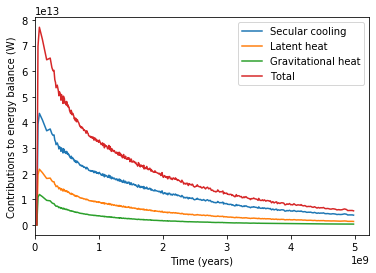

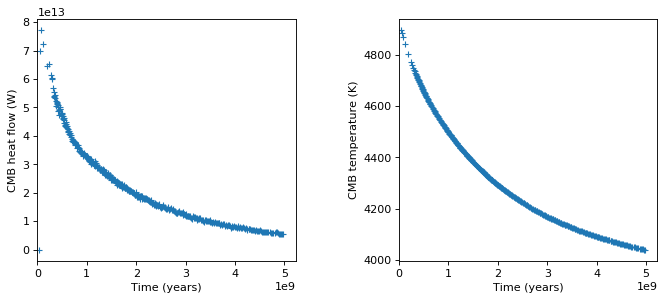

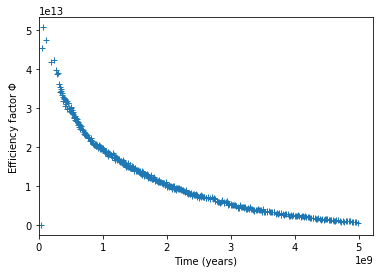

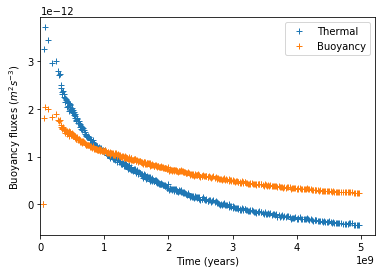

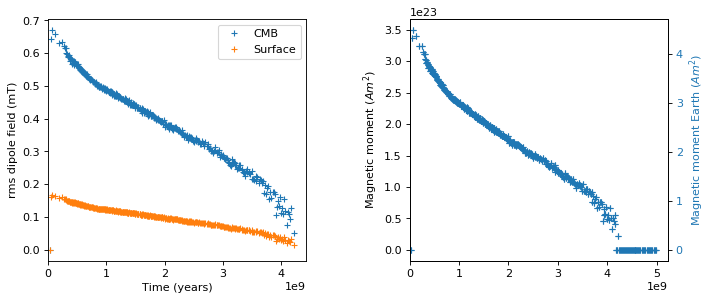

In [6]:
'''Planetary parameters'''
Mp = 1.2
XFe = 50  #50: inner core. 30: no inner core
FeM = 0.00

class Exo(Rocky_Planet):
    
    def parameters(self):
        '''Load all parameter files'''
        self.read_parameters("M_ {:.1f}_Fe_{:.0f}.0000_FeM_{:2.0f}.0000.yaml".format(Mp, XFe, FeM))
        #self.read_parameters("Earth.yaml".format(Mp, XFe, FeM))
        qcmb_ev = pd.read_csv("qc_T_M{:02d}_Fe{:02d}_FeM{:02d}.txt".format(int(10*Mp),int(XFe)+5, int(FeM)), sep=" ", skiprows=1, header=None)
        qcmb_ev.columns = ["time", "qcmb", "Tcmb"]
        self.time_vector = qcmb_ev["time"]
        self.qcmb = qcmb_ev["qcmb"]

if __name__ == '__main__': 
       
    Evolution(Exo()).run() 